<a href="https://colab.research.google.com/github/Deebh/Contextual-Word-Prediction/blob/main/hieMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# 🚀 Step 1: Upload and Load Dataset Efficiently
from google.colab import files
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [43]:

# Upload dataset manually in Google Colab
uploaded = files.upload()

Saving hingconvoupdated.csv to hingconvoupdated (1).csv


In [44]:
import pandas as pd
# Load the dataset (Update the filename if needed)
df = pd.read_csv("hingconvoupdated.csv")

# Display first few rows
df.head()

,Conversation
0,Hey Radhika! Kaisi ho?
1,"Hey Rohan, main bilkul thik hun. Tu bata, kais..."
2,"I'm good too, yaar. Tumne suna ki next week sc..."
3,"Haan, mujhe toh pata chal gaya hai. Itna excit..."
4,"Bilkul, Radhika. Ek trip miss karunga toh beha..."


In [45]:
import re

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply preprocessing to the conversation column
df["Conversation"] = df["Conversation"].astype(str).apply(preprocess_text)

# Display cleaned text
df.head()


,Conversation
0,hey radhika kaisi ho
1,hey rohan main bilkul thik hun tu bata kaisa hai
2,im good too yaar tumne suna ki next week schoo...
3,haan mujhe toh pata chal gaya hai itna excited...
4,bilkul radhika ek trip miss karunga toh behad ...


In [46]:

#PREPROCESS
import re

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply preprocessing to the conversation column
df["Conversation"] = df["Conversation"].astype(str).apply(preprocess_text)

# Display cleaned text
df.head()


,Conversation
0,hey radhika kaisi ho
1,hey rohan main bilkul thik hun tu bata kaisa hai
2,im good too yaar tumne suna ki next week schoo...
3,haan mujhe toh pata chal gaya hai itna excited...
4,bilkul radhika ek trip miss karunga toh behad ...


In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["Conversation"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["Conversation"])


In [48]:
# 🚀 Step 4: Prepare Input-Output Data Efficiently
input_sequences = []
output_words = []

# Set a limit on sequence length to prevent memory overload
max_seq_length = 50  # Adjust based on available RAM

for sequence in sequences:
    for i in range(1, min(len(sequence), max_seq_length)):  # Limit sequence expansion
        input_sequences.append(sequence[:i])
        output_words.append(sequence[i])  # Predict the next word

In [49]:
# 🚀 Step 5: Pad Sequences and Convert Output to Sparse Labels
max_sequence_length = max(len(seq) for seq in input_sequences)  # Find max length for padding

X = pad_sequences(input_sequences, maxlen=max_sequence_length, padding="pre")
y = np.array(output_words)  # Use integer encoding instead of one-hot encoding

In [50]:
# 🚀 Step 6: Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Save processed data to avoid recomputation
np.save("X.npy", X)
np.save("y.npy", y)

In [60]:
# 🚀 Step 7: Define Optimized LSTM Model
vocab_size = len(tokenizer.word_index) + 1  # Total unique words
embedding_dim = 100  # Word vector size
lstm_units = 256  # LSTM cell size

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(units=lstm_units, return_sequences=False),
    Dense(units=vocab_size, activation="softmax")
])

# Compile model using sparse categorical crossentropy to reduce memory usage
lstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [61]:
# 🚀 Step 8: Train the Model with Smaller Batch Size
history = lstm_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.0637 - loss: 6.7138 - val_accuracy: 0.1372 - val_loss: 5.5829
Epoch 2/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.1590 - loss: 5.2018 - val_accuracy: 0.1822 - val_loss: 5.2362


In [62]:
lstm_model.save("hinglish_lstm_model.keras")

In [53]:
# 🚀 Step 10: Function to Predict the Next Word
def predict_next_word(input_text, tokenizer, model, max_sequence_length):
    input_text = preprocess_text(input_text)  # Apply preprocessing
    sequence = tokenizer.texts_to_sequences([input_text])[0]  # Tokenize input
    sequence = pad_sequences([sequence], maxlen=max_sequence_length, padding="pre")  # Pad sequence

    predicted_index = np.argmax(model.predict(sequence), axis=-1)  # Get most probable word index
    predicted_word = tokenizer.index_word.get(predicted_index[0], "")  # Convert index to word

    return predicted_word

In [54]:
# 🚀 Step 11: Prompt User Input and Predict Top 3 Next Words
def predict_top_words(input_text, tokenizer, model, max_sequence_length, top_n=3):
    input_text = preprocess_text(input_text)  # Apply preprocessing
    sequence = tokenizer.texts_to_sequences([input_text])[0]  # Tokenize input
    sequence = pad_sequences([sequence], maxlen=max_sequence_length, padding="pre")  # Pad sequence

    predictions = model.predict(sequence)[0]  # Get probability distribution
    top_indices = np.argsort(predictions)[-top_n:][::-1]  # Get top N word indices

    top_words = [tokenizer.index_word.get(idx, "") for idx in top_indices]  # Convert indices to words

    return top_words

# Prompt user for input text
input_text = input("Enter a Hinglish phrase: ")

# Predict top 3 most probable next words
predicted_words = predict_top_words(input_text, tokenizer, model, max_sequence_length)
print(f"Predicted next words: {predicted_words}")


Enter a Hinglish phrase: hi how
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Predicted next words: ['you', 'do', 'can']


In [57]:
#Step 12: Implement BiLSTM & GRU Models
from tensorflow.keras.layers import Bidirectional

# 🚀 Define BiLSTM Model
bilstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(units=lstm_units, return_sequences=False)),  # Bidirectional LSTM
    Dense(units=vocab_size, activation="softmax")
])

# Compile the BiLSTM model
bilstm_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 🚀 Train the BiLSTM Model
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))

# Save the BiLSTM Model
bilstm_model.save("hinglish_bilstm_model.keras")


Epoch 1/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - accuracy: 0.0718 - loss: 6.6220 - val_accuracy: 0.1474 - val_loss: 5.5108
Epoch 2/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 67s 15ms/step - accuracy: 0.1702 - loss: 5.0798 - val_accuracy: 0.1849 - val_loss: 5.1892


In [59]:
# implement GRU
from tensorflow.keras.layers import GRU

# 🚀 Define GRU Model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(units=lstm_units, return_sequences=False),  # GRU Layer
    Dense(units=vocab_size, activation="softmax")
])

# Compile the GRU model
gru_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 🚀 Train the GRU Model
history_gru = gru_model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_val, y_val))

# Save the GRU Model
gru_model.save("hinglish_gru_model.keras")

Epoch 1/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - accuracy: 0.0775 - loss: 6.6111 - val_accuracy: 0.1631 - val_loss: 5.4163
Epoch 2/2
4579/4579 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.1842 - loss: 4.9560 - val_accuracy: 0.1964 - val_loss: 5.1244


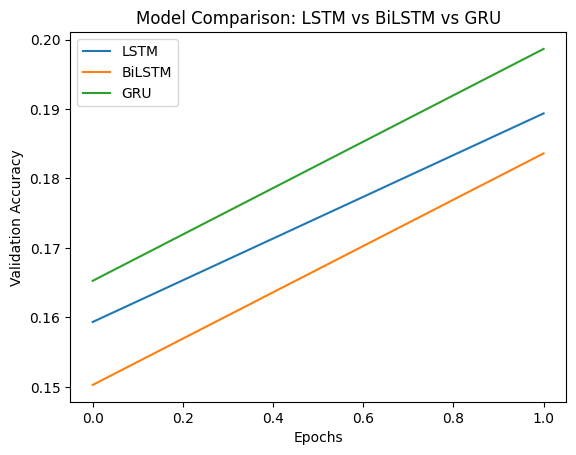

In [33]:
#comparing the performance
import matplotlib.pyplot as plt

# Plot training & validation accuracy for all models
plt.plot(history.history['val_accuracy'], label='LSTM')
plt.plot(history_bilstm.history['val_accuracy'], label='BiLSTM')
plt.plot(history_gru.history['val_accuracy'], label='GRU')

plt.title('Model Comparison: LSTM vs BiLSTM vs GRU')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

In [38]:
import os

# Get absolute paths of model files
print(os.path.abspath("hinglish_lstm_model.h5"))
print(os.path.abspath("hinglish_bilstm_model.h5"))
print(os.path.abspath("hinglish_gru_model.h5"))



/content/hinglish_lstm_model.h5
/content/hinglish_bilstm_model.h5
/content/hinglish_gru_model.h5


In [76]:
#step 13
import numpy as np
from tensorflow.keras.models import load_model

# Load all trained models
lstm_model = load_model("hinglish_lstm_model.keras")
bilstm_model = load_model("hinglish_bilstm_model.keras")
gru_model = load_model("hinglish_gru_model.keras")

# 🚀 Function to Predict Next Words Using a Selected Model
def predict_next_words(input_text, model_choice, tokenizer, max_sequence_length, top_n=3):
    input_text = preprocess_text(input_text)  # Apply preprocessing
    sequence = tokenizer.texts_to_sequences([input_text])[0]  # Tokenize input
    sequence = pad_sequences([sequence], maxlen=max_sequence_length, padding="pre")  # Pad sequence

    # Convert user input to lowercase to make it case-insensitive
    model_choice = model_choice.strip().lower()

    # Select model based on user input
    if model_choice == "lstm":
        model = lstm_model
    elif model_choice == "bilstm":
        model = bilstm_model
    elif model_choice == "gru":
        model = gru_model
    else:
        print("Invalid model choice! Using LSTM by default.")
        model = lstm_model

    predictions = model.predict(sequence)[0]  # Get probability distribution
    top_indices = np.argsort(predictions)[-top_n:][::-1]  # Get top N word indices

    top_words = [tokenizer.index_word.get(idx, "") for idx in top_indices]  # Convert indices to words

    return top_words

# 🚀 User Prompt to Select Model and Input Text
model_choice = input("Choose a model (LSTM / BiLSTM / GRU): ").strip().lower()
input_text = input("Enter a Hinglish phrase: ")

# Predict using the chosen model
predicted_words = predict_next_words(input_text, model_choice, tokenizer, max_sequence_length)
print(f"Predicted next words using {model_choice.upper()}: {predicted_words}")


Choose a model (LSTM / BiLSTM / GRU): gru
Enter a Hinglish phrase: hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted next words using GRU: ['rahul', 'rohan', 'riya']


In [ ]:
#Step 14: Implementing the transformer Model
